In [4]:
# Sentiment Analysis - Phase 0
# Install libraries
!pip3 install numpy
!pip3 install opencv-python
!pip3 install torch

# Download the dataset
!wget "https://raw.githubusercontent.com/XL2248/MSCTD/main/MSCTD_data/ende/english_train.txt"
!wget "https://raw.githubusercontent.com/XL2248/MSCTD/main/MSCTD_data/ende/english_test.txt"
!wget "https://raw.githubusercontent.com/XL2248/MSCTD/main/MSCTD_data/ende/english_dev.txt"
!wget "https://raw.githubusercontent.com/XL2248/MSCTD/main/MSCTD_data/ende/image_index_train.txt"
!wget "https://raw.githubusercontent.com/XL2248/MSCTD/main/MSCTD_data/ende/image_index_test.txt"
!wget "https://raw.githubusercontent.com/XL2248/MSCTD/main/MSCTD_data/ende/image_index_dev.txtt"
!wget "https://raw.githubusercontent.com/XL2248/MSCTD/main/MSCTD_data/ende/sentiment_train.txt"
!wget "https://raw.githubusercontent.com/XL2248/MSCTD/main/MSCTD_data/ende/sentiment_test.txt"
!wget "https://raw.githubusercontent.com/XL2248/MSCTD/main/MSCTD_data/ende/sentiment_dev.txt"

!pip install --upgrade --no-cache-dir gdown
!gdown "1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj&export=download"
!unzip "/content/train_ende.zip"

!gdown "1B9ZFmSTqfTMaqJ15nQDrRNLqBvo-B39W&export=download"
!unzip "/content/test.zip"

!gdown "12HM8uVNjFg-HRZ15ADue4oLGFAYQwvTA&export=download"
!unzip "/content/dev.zip"


Streaming output truncated to the last 5000 lines.
  inflating: dev/1054.jpg            
  inflating: dev/1055.jpg            
  inflating: dev/1056.jpg            
  inflating: dev/1057.jpg            
  inflating: dev/1058.jpg            
  inflating: dev/1059.jpg            
  inflating: dev/106.jpg             
  inflating: dev/1060.jpg            
  inflating: dev/1061.jpg            
  inflating: dev/1062.jpg            
  inflating: dev/1063.jpg            
  inflating: dev/1064.jpg            
  inflating: dev/1065.jpg            
  inflating: dev/1066.jpg            
  inflating: dev/1067.jpg            
  inflating: dev/1068.jpg            
  inflating: dev/1069.jpg            
  inflating: dev/107.jpg             
  inflating: dev/1070.jpg            
  inflating: dev/1071.jpg            
  inflating: dev/1072.jpg            
  inflating: dev/1073.jpg            
  inflating: dev/1074.jpg            
  inflating: dev/1075.jpg            
  inflating: dev/1076.jpg            

tensor([[[[ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 2.],
          [ 0.],
          [ 1.],
          [ 2.],
          [ 2.],
          [ 0.],
          [ 2.],
          [ 0.],
          [ 2.],
          [-1.],
          [-1.],
          [-1.],
          [-1.],
          [-1.],
          [-1.],
          [-1.]]]], dtype=torch.float64) tensor([[[[ 901,   22,  107,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
             -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1],
          [  90,    5,  174,  176,   67,  152,   21,   37,  158,  761, 4646,
             -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1],
          [  33,   33,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
             -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1],
          [   5, 5201, 6184,  564,  512,   83,   20, 1059,   -1,   -1,   -1,
             -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1],
          [6263, 2190,   89,    5,   40,   -1,   -1,   -1,   -1,   -1,   -1,
           

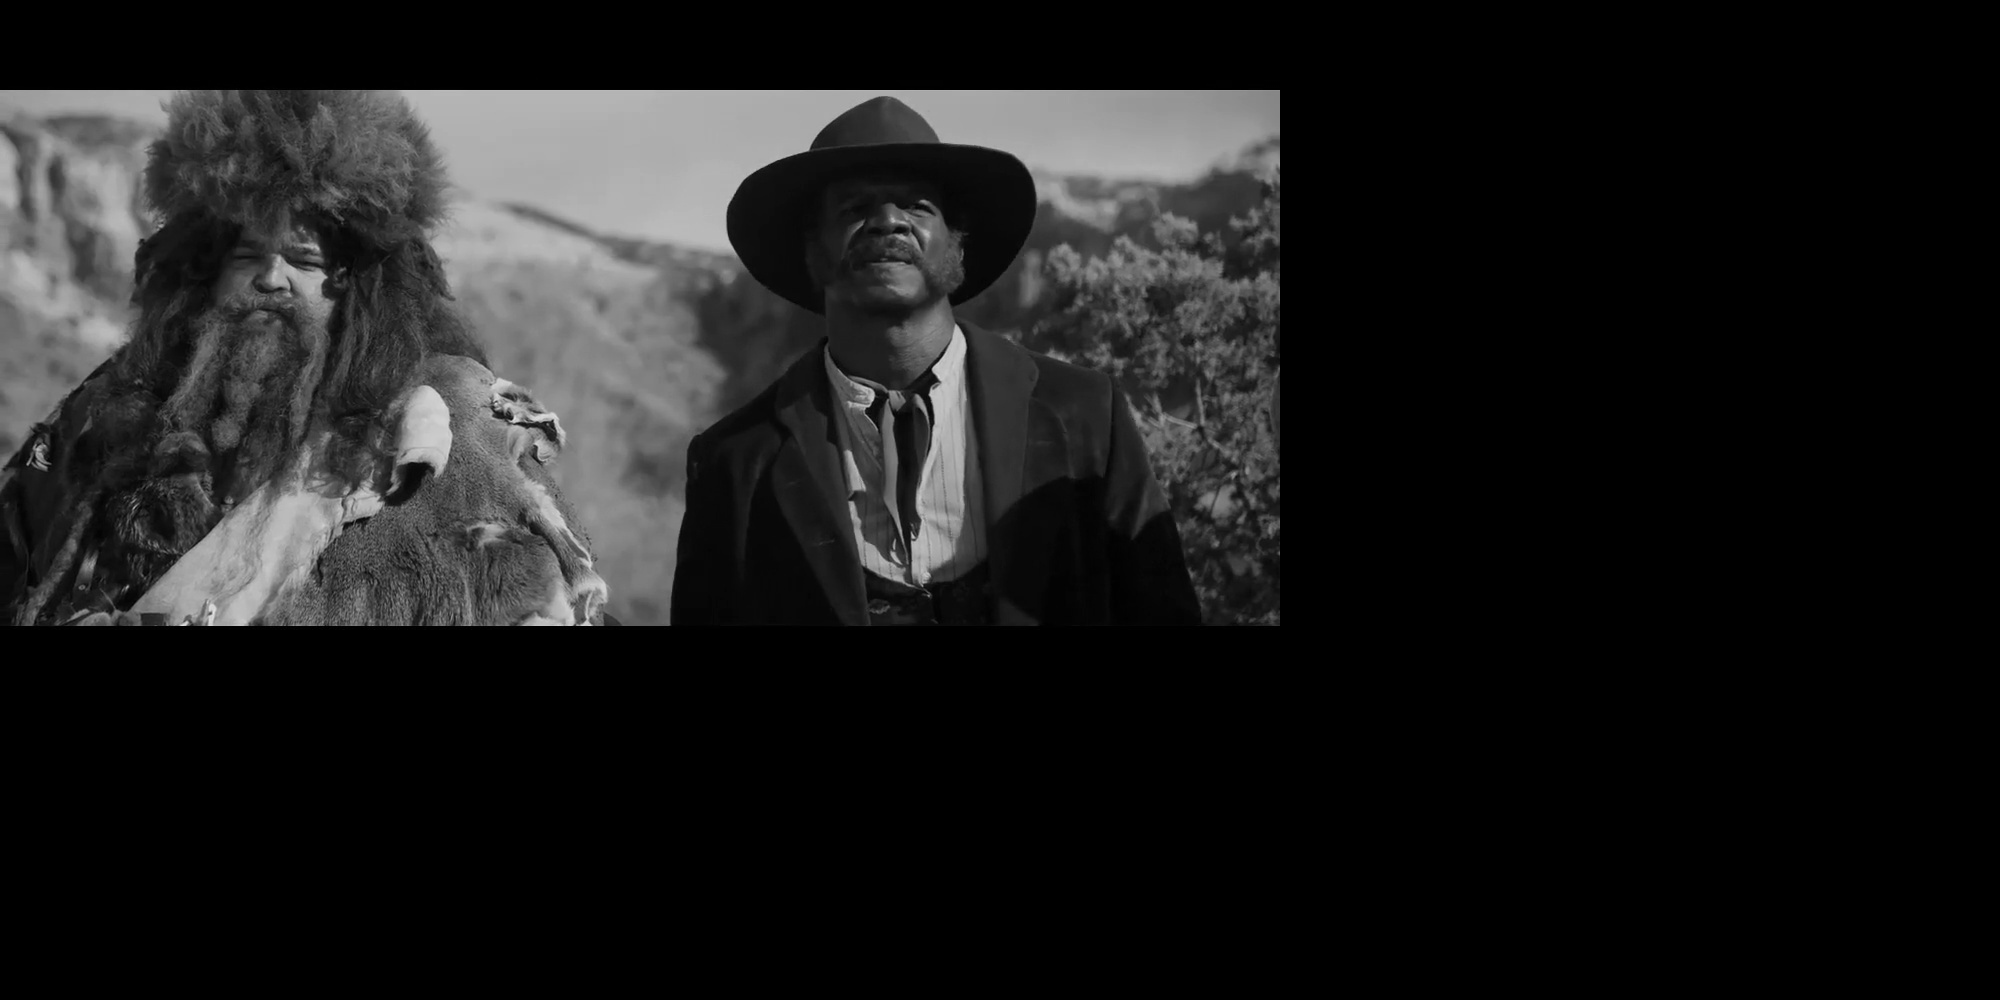

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchvision.transforms import ToTensor
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from google.colab.patches import cv2_imshow
import numpy as np
from io import StringIO
import string
import cv2

# Part 1
# In order to convert lexical data into numeric format we assume a vocabulary
def build_vocabulary(text_path):

  tokenizer = get_tokenizer('basic_english')
  with open(text_path) as text_reader:
      text = text_reader.read().split("\n")
      tokenized_text = []
      for sentence in text:
        sentence =  tokenizer(sentence)
        tokenized_text.append(sentence)
  unk_token = '<unk>'
  builded_vocab = build_vocab_from_iterator(tokenized_text, specials = [unk_token])
  builded_vocab.set_default_index(-10)
  return builded_vocab


# This function replaces given punc with char in the text
def replace_all(text, puncs, char):
    for punc in puncs:
      text = text.replace(punc, char)
    return text


# Dataset class
class SentimentDataset(Dataset):
  def __init__(self, text_path, image_path, label_path, rawimage_path, low_ram = True):
    
    # Assign modalities path 
    self.text_path = text_path
    self.image_path = image_path
    self.rawimage_path = rawimage_path
    self.label_path = label_path

    # If images are not required, low ram mode is on
    self.low_ram = low_ram

    # Make a vocabulary for text data
    self.vocab = build_vocabulary(self.text_path)
    self.tokenizer = get_tokenizer('basic_english')

    # Transform data to tensor 
    self.transform = ToTensor()

    # Read the text data, clean from punctuations, and split sentences in a list
    with open(self.text_path) as text_reader:
      full_text = replace_all(text_reader.read(), string.punctuation, "").split("\n")

    # Tokenize sentences and use vocab dictionary to convert to numercial data
    temp_text = []
    for t in full_text:
      temp_text.append(self.vocab(self.tokenizer(t)))
    full_text = temp_text

    # Padding the text data to obtain sentences with same size
    max_len = max([len(t) for t in full_text]) 

    for t in full_text:
      t += [-1] * (max_len - len(t))
    
    full_text = [[[t] for t in text] for text in full_text]
    self.full_text = full_text

    # Read labels from file
    with open(self.label_path) as label_reader:
      self.full_labels = np.loadtxt(label_reader)
    
    # Since images require high RAM, we load images when they are needed

  def __len__(self):

    # In this dataset we assume each utterance as a sample
    # Get the number of utterances

    with open(self.image_path) as image_reader:
      samples = image_reader.read().split("\n")
    self.len = len(samples)-1
    return self.len

  def __getitem__(self, idx):

    # Get the modalities ID of each utterance(Sample)
    # Load the IDs text and get a list of IDs
    with open(self.image_path) as image_reader:
      utterance_indices = image_reader.read().split("\n")[idx]

    utterance_indices = utterance_indices.replace("[", "")
    utterance_indices = utterance_indices.replace("]", "")
    utterance_indices = np.loadtxt(StringIO(utterance_indices), delimiter=",")

    # Make IDs list the same size and convert it to Tensor
    tempindices = np.ones(20-utterance_indices.shape[0], dtype= int)*-1
    tempindices = np.append(utterance_indices, tempindices, axis = 0)
    tempindices = np.expand_dims(tempindices, axis = 0)

    self.utterance_indices = self.transform(np.asarray(tempindices))


    # Get Images of required utterance (if images are needed)
    if not self.low_ram:
      utterance_images = []
      for index in utterance_indices:
        im = cv2.imread(self.rawimage_path+ str(int(index)) + ".jpg")
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        utterance_images.append(im)

      # Padding images in utterance 
      padded_ = []
      for image in utterance_images:
        new_image = np.zeros((1000 - image.shape[0], image.shape[1]), dtype='uint8')
        image = np.append(image, new_image, axis = 0)
        new_image = np.zeros((image.shape[0], 2000-image.shape[1]), dtype='uint8')
        image = np.append(image, new_image, axis = 1)
        padded_.append(image)

      temp = np.zeros((20-len(padded_),image.shape[0], image.shape[1]), dtype='uint8')
      temp = np.append(np.asarray(padded_),temp, axis = 0)
      self.utterance_image = temp
 

    # Get text of required utterance
    utterance_text = []
    for index in utterance_indices:
      utterance_text.append(self.full_text[int(index)]) 
    utterance_text = np.asarray(utterance_text)

    # Padding the text and convert the list to Tensor
    temptext = np.ones((20-utterance_text.shape[0], utterance_text.shape[1], utterance_text.shape[2])) * -1
    temptext = np.append(utterance_text, temptext, axis = 0)
    self.utterance_text = self.transform(np.asarray(temptext).astype(int))

    # Get Labels of utternace
    utterance_labels = []
    for index in utterance_indices:
      utterance_labels.append([self.full_labels[int(index)]])
    utterance_labels = np.asarray(utterance_labels)

    # Padding the labels and convert the list to Tensor
    templabels = np.ones((20-utterance_labels.shape[0], utterance_labels.shape[1]))*-1
    templabels = np.append(utterance_labels, templabels, axis = 0)
    self.utterance_labels = self.transform(np.asarray(templabels))


    if self.low_ram:
      return {'text': self.utterance_text, 'label': self.utterance_labels, 'indices': self.utterance_indices}

    else:
      return {'image': self.utterance_image, 'text': self.utterance_text, 'label': self.utterance_labels, 'indices': self.utterance_indices}


# Now the dataset is ready to use with data loader 

text_path = "/content/english_train.txt"
image_path = "/content/image_index_train.txt"
label_path = "/content/sentiment_train.txt"
rawimage_path = "/content/train_ende/"

dataset = SentimentDataset(text_path, image_path, label_path, rawimage_path, low_ram = False)
data_loader = DataLoader(dataset, batch_size=1, shuffle = True)

sample = next(iter(data_loader))

print(sample['label'], sample['text'], sample['indices'])
cv2_imshow(sample['image'][0][0].numpy())

(array([6922, 7835, 5483]), array([0, 1, 2, 3]))


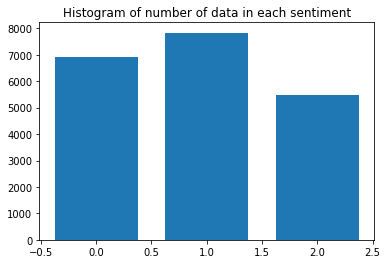

In [6]:
# Part 2
# Question 1

import matplotlib.pyplot as plt

text_path = "/content/english_train.txt"
image_path = "/content/image_index_train.txt"
label_path = "/content/sentiment_train.txt"
rawimage_path = "/content/train_ende/"

dataset = SentimentDataset(text_path, image_path, label_path, rawimage_path, low_ram = True)
data_loader = DataLoader(dataset, batch_size=1, shuffle = True)

def Question_1():

  sentiments = []
  for batch in data_loader:
    sentiments = sentiments + batch['label'].tolist()

  all_sentiments = []
  for i in range(len(sentiments)):

    all_sentiments = all_sentiments+ sentiments[i][0]

  all_sentiments = [all_sentiments[i][0] for i in range(len(all_sentiments))]
  while -1 in all_sentiments:
    all_sentiments.remove(-1)

  question_1_hist = np.histogram(all_sentiments, bins = range(0, len(np.unique(all_sentiments))+1))
  print(question_1_hist)

  plt.hist(np.asarray(all_sentiments).astype(int), bins=range(0, len(np.unique(all_sentiments))+1), align='left', rwidth=0.75)
  
  plt.title("Histogram of number of data in each sentiment")
  plt.show()


Question_1()

Mean and variance:  6.461758893280632 ,  9.245672005108656
Histogram:  (array([   0,  824, 1186, 1515, 1870, 2738, 2668, 2424, 2051, 1624, 1249,
        901,  563,  312,  155,   97,   43,   14,    6]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19]))


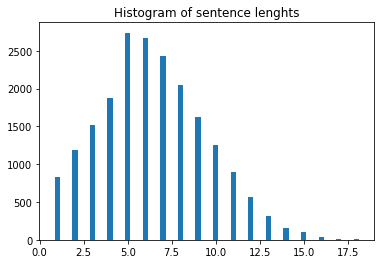

In [7]:
import matplotlib.pyplot as plt
# Part 2
# Question 2

text_path = "/content/english_train.txt"
image_path = "/content/image_index_train.txt"
label_path = "/content/sentiment_train.txt"
rawimage_path = "/content/train_ende/"

dataset = SentimentDataset(text_path, image_path, label_path, rawimage_path, low_ram = True)
data_loader = DataLoader(dataset, batch_size=1, shuffle = True)

def sentence_len(sentence, padd_int):

  while padd_int in sentence:
    sentence.remove(padd_int)
  return len(sentence)

def Question_2():
  text = []
  sentiment = []

  for batch in data_loader:
    text = text + batch['text'].tolist()

  # text
  all_text = []
  for i in range(len(text)):
    all_text = all_text+ text[i][0]

  sentence_lenghts = [sentence_len(text, -1) for text in all_text]
  while 0 in sentence_lenghts:
    sentence_lenghts.remove(0)

  print("Mean and variance: ", np.mean(sentence_lenghts),", ", np.var(sentence_lenghts))

  question_2_hist = np.histogram(np.asarray(sentence_lenghts), bins = range(0, 1+np.max(np.unique(sentence_lenghts))) )
  print("Histogram: ", question_2_hist)

  plt.hist(sentence_lenghts, bins=range(1, 1+np.max(np.unique(sentence_lenghts))), align='left', rwidth=0.3)
  
  plt.title("Histogram of sentence lenghts")
  plt.show()

Question_2()

Mean and variance:  9.796708615682478 ,  17.696329921871556
Histogram:  (array([  0,   0,   0,   0,   0, 341, 236, 228, 194, 163, 136, 112, 125,
        99,  90,  65,  80,  64,  46,  87]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20]))


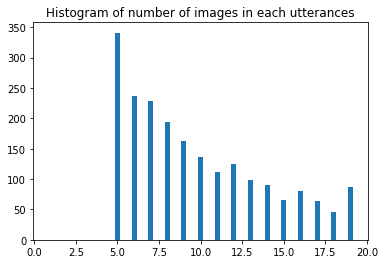

In [8]:
# Part 2
# Question 3

text_path = "/content/english_train.txt"
image_path = "/content/image_index_train.txt"
label_path = "/content/sentiment_train.txt"
rawimage_path = "/content/train_ende/"

dataset = SentimentDataset(text_path, image_path, label_path, rawimage_path, low_ram = True)
data_loader = DataLoader(dataset, batch_size=1, shuffle = True)

def Question_3():

  images = []
  for batch in data_loader:
    images = images + batch['indices'].tolist()
  
  images = [images[i][0][0] for i in range(len(images))] 

  for image in images:
    while -1 in image:
      image.remove(-1)

  image_numbers = []
  for image in images:
    image_numbers.append(len(image))
  
  print("Mean and variance: ", np.mean(image_numbers), ", ", np.var(image_numbers))

  question_3_hist = np.histogram(np.asarray(image_numbers), bins = range(0, 1+np.max(np.unique(image_numbers))) )
  print("Histogram: ", question_3_hist)

  plt.hist(image_numbers, bins=range(1, 1+np.max(np.unique(image_numbers))), align='left', rwidth=0.3)
  
  plt.title("Histogram of number of images in each utterances")
  plt.show()
  

Question_3()

In [9]:
!wget "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"

--2023-01-06 11:25:59--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.05s   

2023-01-06 11:25:59 (19.4 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



Mean and variance of face numbers:  1.4241106719367589 ,  3.4714147229295875
Histogram of face numbers (array([5455, 7785, 3884, 1666,  700,  298,  172,   91,   56,   41,   23,
         12,   14,    5,    8,    5,    4,    2,    2,    1,    5,    1,
          0,    0,    0,    1,    0,    2,    0,    0,    0,    0,    0,
          0,    0,    1,    0,    2,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    1,    1,    0,    0,    1,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    1]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]

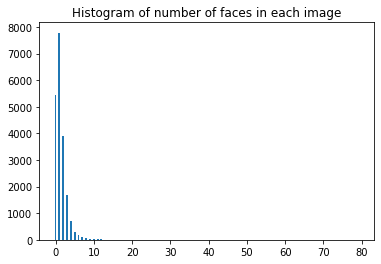

In [10]:
# Part 2
# Question 4

# Warning! This section may takes long time due to loading images and face recognition

import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

def count_faces(text_path, image_path, label_path, rawimage_path):

  face_cascade  = cv2.CascadeClassifier("/content/haarcascade_frontalface_default.xml")

  dataset = SentimentDataset(text_path, image_path, label_path, rawimage_path, low_ram = False)
  data_loader = DataLoader(dataset, batch_size=1, shuffle = True)

  face_numbers = []

  i = 0
  for batch in data_loader:
    # if i>100:
    #   break
    # i += 1
    images = batch['image'][0]
    indices = batch['indices'][0][0][0].tolist()

    for image, index in zip(images, indices):
      
      if int(index) != -1:
        image = image.numpy()
        # cv2_imshow(image)
        faces = face_cascade.detectMultiScale(image, 1.1, 4)
        face_numbers.append(len(faces))

    del batch

  return face_numbers  


def Question_4():
  text_path = "/content/english_train.txt"
  image_path = "/content/image_index_train.txt"
  label_path = "/content/sentiment_train.txt"
  rawimage_path = "/content/train_ende/"

  face_nums = count_faces(text_path, image_path, label_path, rawimage_path)
  print("Mean and variance of face numbers: ", np.mean(face_nums), ", ", np.var(face_nums))

  question_4_hist = np.histogram(face_nums, bins = range(0, max(face_nums)+1))
  print("Histogram of face numbers", question_4_hist)

  plt.hist(np.asarray(face_nums).astype(int), bins=range(0, max(face_nums)+1), align='left', rwidth=0.5)
  
  plt.title("Histogram of number of faces in each image")
  plt.show()


Question_4()

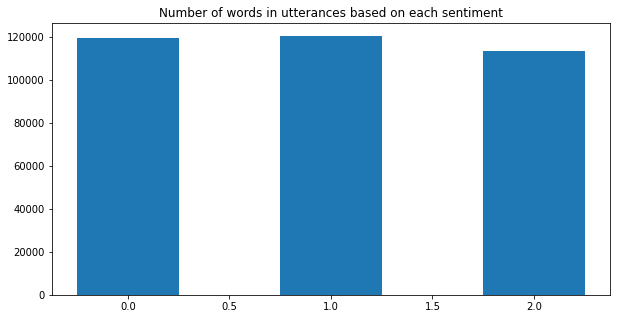

In [11]:
# Question 5

dataset = SentimentDataset(text_path, image_path, label_path, rawimage_path, low_ram = True)
data_loader = DataLoader(dataset, batch_size=1, shuffle = True)

def Question_5():
  text = []
  sentiment = []

  for batch in data_loader:
    text = text + batch['text'].tolist()
    sentiment = sentiment + batch['label'].tolist()

  sentiment = [sentiment[i][0] for i in range(len(sentiment))] 
  text = [text[i][0] for i in range(len(text))]

  for utterance in text:
    for sentence in utterance:
      while -1 in sentence:
        sentence.remove(-1)


  # utterance lengths contains number of words in each utterance
  utterance_lengths = []

  for utterance in text:
    sum = 0
    for sentence in utterance:
      sum = sum + len(sentence)
    utterance_lengths.append(sum)

  for utterance in sentiment:
    for sentence in utterance:
      while -1 in sentence:
        sentence.remove(-1)
  
  utterance_sentiments = []
  for utterance in sentiment:
    temp = []
    for sentence in utterance: 
      if len(sentence)>0:
        temp.append(sentence[0])
    utterance_sentiments.append(temp)

  #unique sentiments in each utterance
  unique_sentiments = []
  for utterance in utterance_sentiments:
    unique_sentiments.append(np.unique(utterance))


  all_sentiments = []
  for sentiment in unique_sentiments:
    all_sentiments += sentiment.tolist()

  all_sentiments = np.unique(np.asarray(all_sentiments))

  utt_len_per_sentiment = []
  
  for label in all_sentiments:
    temp = []
    for i in range(len(unique_sentiments)):
      if label in unique_sentiments[i]:
        temp.append(utterance_lengths[i])
    utt_len_per_sentiment.append(temp)

  utt_len = [np.sum(utt_len_per_sentiment[i]) for i in range(len(utt_len_per_sentiment))]

  fig = plt.figure(figsize = (10, 5))
  plt.bar(all_sentiments ,utt_len, width = 0.5)

  plt.title("Number of words in utterances based on each sentiment")
  plt.show()

Question_5()


Histogram of patterns [ 1.  2.  1. 61.  1.  2. 12.  6. 17. 44.  1. 34. 40. 11.  1.  3.  1.  1.
  2.  4.  1.  1.  2. 36.  1.  5.  1. 30.  5.  1.  4.  1.  2. 19.  7.  1.
 16. 31. 18.  6.  1.  3.  8. 20. 28. 15.  3.  2.  7.  5.  2.  2.  1.  3.
  8.  1. 22. 16. 39.  6.  9.  4. 19. 15. 35.  9.  1.  1. 27. 16.  4.  3.
  5.  2.  3.  1.  8.  1.  1.  1.  1.  1. 20.  7.  2. 12.  2. 16. 12.  1.
  3.  2.  3. 16.  1.  3. 14.  2.  1. 27.  4.  1.  1.  3.  1.  4.  1.  1.
  1.  1.  1.  1.  2.  4.  1.  5.  3.  1.  1.  2.  2. 17.  6. 16.  4.  2.
  7.  1.  1.  1.  9.  3.  3.  1. 15.  3.  1.  8.  5.  1.  3.  2. 31.  1.
  2.  1.  1.  2.  1.  1.  7.  1.  2.  2.  9.  1.  1.  1.  8.  3.  1.  1.
  4.  1.  1.  1. 27.  6.  3.  8.  2.  2.  9.  1.  2. 10.  2.  1.  1.  1.
  4.  2.  1.  1. 10.  2.  1.  1.  1.  5.  4.  9. 17.  1.  3.  1.  1.  2.
  1.  2.  4.  1.  1.  1.  1.  1. 10. 10.  2.  1.  1.  1.  2.  2.  2.  3.
  1.  8.  2.  1.  1.  1.  2.  1.  1.  5.  8.  2.  1.  7.  1.  1.  1.  5.
  1.  1.  5.  5. 11.  1.  3. 

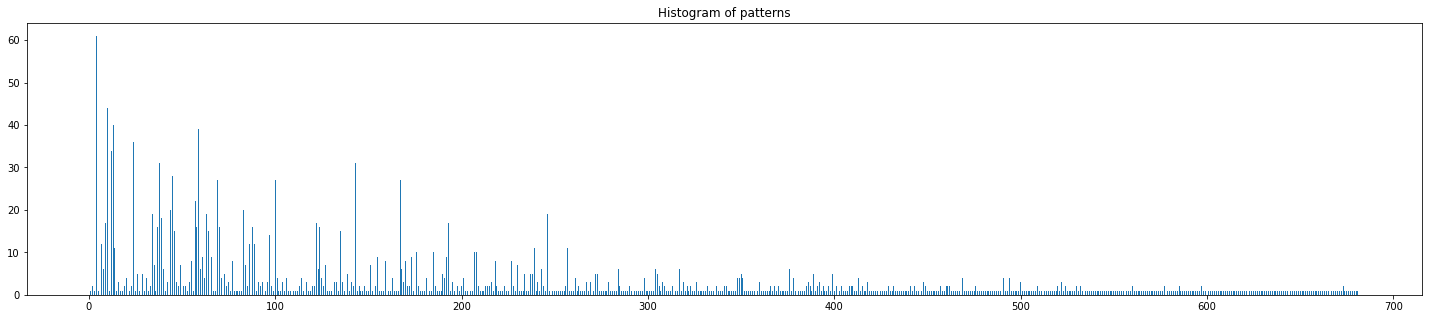

In [12]:
# Part 2
# Question 6

dataset = SentimentDataset(text_path, image_path, label_path, rawimage_path, low_ram = True)
data_loader = DataLoader(dataset, batch_size=1, shuffle = True)

# This function extract the pattern from given labels
def make_pattern(dpattern):
  pre = -10
  pattern = []
  for element in dpattern:
    if element != pre:
      pattern.append(element)
      pre = element

  return pattern


def Question_6():

  sentiments = []
  for batch in data_loader:
    sentiments = sentiments + batch['label'].tolist()

  sentiments = [sentiments[i][0] for i in range(len(sentiments))] 

  sentiment_patterns = []
  for sentiment in sentiments:
    temp = []
    for s in sentiment:
      temp.append(s[0])
    sentiment_patterns.append(temp)

  for sentiment in sentiment_patterns:
    while -1 in sentiment:
      sentiment.remove(-1)

  temp = []
  for sentiment in sentiment_patterns:
    temp.append(make_pattern(sentiment))

  sentiment_patterns = temp

  unique_patterns = []
  for pattern in sentiment_patterns:
    if pattern not in unique_patterns:
      unique_patterns.append(pattern)

  count = np.zeros(len(unique_patterns))
  for pattern in sentiment_patterns:
    index = unique_patterns.index(pattern)
    count[index] += 1
  
  print("Histogram of patterns", count, unique_patterns)
  fig = plt.figure(figsize = (25, 5))
  plt.bar(range(1, len(unique_patterns)+1) ,count, width = 0.5)

  plt.title("Histogram of patterns")
  plt.show()

 

Question_6()

In [13]:
# Part 2
# Question 7


dataset = SentimentDataset(text_path, image_path, label_path, rawimage_path, low_ram = True)
data_loader = DataLoader(dataset, batch_size=1, shuffle = True)

def Question_7():

  sentiments = []
  for batch in data_loader:
    sentiments = sentiments + batch['label'].tolist()
  
  sentiments = [sentiments[i][0] for i in range(len(sentiments))] 

  for utterance in sentiments:
    for sentence in utterance:
      while -1 in sentence:
        sentence.remove(-1)
  
  utterance_lens = []
  for utt in sentiments:
    sum = 0
    for sentence in utt:
      if len(sentence)>0:
        sum +=1 
 
    utterance_lens.append(sum)


  print("mean length of utterance: ", np.mean(utterance_lens))


Question_7()




mean length of utterance:  9.796708615682478


The Possible pattern classes for 9 sentiments can be obtained by: 3*2^8 = 768 which is similar to the number of classes in previouse section